In [1]:
import ast
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
import pandas as pd

import torch_scatter
import transformers
import findkit
from sklearn import preprocessing
import findkit

In [2]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

In [3]:
%matplotlib inline

In [4]:
#This list the defines the different programm codes
code = ["""def sort_list(x):
   return sorted(x)""",
"""def count_above_threshold(elements, threshold=0):
    counter = 0
    for e in elements:
        if e > threshold:
            counter += 1
    return counter""",
"""def find_min_max(elements):
    min_ele = 99999
    max_ele = -99999
    for e in elements:
        if e < min_ele:
            min_ele = e
        if e > max_ele:
            max_ele = e
    return min_ele, max_ele"""]
    

# Encode our code into the vector space

In [5]:
%%time
sentence_model = SentenceTransformer("flax-sentence-embeddings/st-codesearch-distilroberta-base")

CPU times: user 1.15 s, sys: 181 ms, total: 1.33 s
Wall time: 7.31 s


In [6]:
sentence_model = sentence_model.cuda()

In [8]:
code_emb = sentence_model.encode(code, convert_to_tensor=True)

In [9]:
#!wc -l ../../output/python_functions.csv

In [94]:
%%time
raw_functions_all = pd.read_csv("../../output/python_functions.csv", nrows=1e7)

CPU times: user 42.5 s, sys: 1.16 s, total: 43.7 s
Wall time: 43.7 s


In [95]:
raw_functions = raw_functions_all.iloc[::50]

In [11]:
raw_functions.shape

(136029, 5)

In [12]:
paperswithcode_df = pd.read_csv("../../data/paperswithcode_with_tasks.csv")

In [13]:
paperswithcode_df['tasks'] = paperswithcode_df['tasks'].apply(ast.literal_eval)

In [14]:
functions = raw_functions.merge(paperswithcode_df[['repo', 'tasks']], left_on='repo_name', right_on='repo').drop(columns=["repo"])

In [15]:
functions['repo_name'].value_counts().head(20)

google-research/google-research                      21045
osmr/imgclsmob                                       18787
tensorflow/models                                    11582
huggingface/transformers                              5861
pytorch/fairseq                                       1160
rwightman/pytorch-image-models                        1030
tensorflow/tensor2tensor                              1029
PaddlePaddle/Research                                  474
joe-prog/https-github.com-facebookresearch-ParlAI      429
pytorch/vision                                         413
pytorch/pytorch                                        385
VLOGroup/tensorflow-icg                                328
yumoh/catboost_iter                                    317
Daikenan/LTMU                                          316
Saibo-creator/Text-Summrize-Project                    301
dmlc/dgl                                               246
open-mmlab/mmsegmentation                              2

In [16]:
functions = functions[~functions['repo_name'].isin(["google-research/google-research", "osmr/imgclsmob", "tensorflow/models", "tensorflow/tensor2tensor"])]

In [17]:
paperswithcode_df[paperswithcode_df['repo'] == "google-research/google-research"]

,Unnamed: 0,paper_url,paper_title,paper_arxiv_id,paper_url_abs,paper_url_pdf,repo_url,mentioned_in_paper,mentioned_in_github,framework,repo,title,abstract,tasks,least_common_task
21367,21367,https://paperswithcode.com/paper/unsupervised-...,Unsupervised Learning of Object Structure and ...,1906.07889,https://arxiv.org/abs/1906.07889v3,https://arxiv.org/pdf/1906.07889v3.pdf,https://github.com/google-research/google-rese...,False,False,tf,google-research/google-research,Unsupervised Learning of Object Structure and ...,Extracting and predicting object structure and...,"[action recognition, continuous control, objec...",action recognition


In [18]:
paperswithcode_df[paperswithcode_df['repo'].isin(functions['repo_name'].value_counts().head(20).index)][['paper_title', 'repo', 'tasks']]

,paper_title,repo,tasks
2348,High-Performance Long-Term Tracking with Meta-...,Daikenan/LTMU,[visual tracking]
7789,PLATO: Pre-trained Dialogue Generation Model w...,PaddlePaddle/Research,"[dialogue generation, question answering, text..."
8876,MeanSum: A Neural Model for Unsupervised Multi...,Saibo-creator/Text-Summrize-Project,[abstractive text summarization]
10612,On learning optimized reaction diffusion proce...,VLOGroup/tensorflow-icg,[image restoration]
18605,Graph InfoClust: Leveraging cluster-level node...,dmlc/dgl,"[graph representation learning, link predictio..."
23130,Exploring the Limits of Transfer Learning with...,huggingface/transformers,"[abstractive text summarization, common sense ..."
24653,Mask R-CNN,jiajunhua/facebookresearch-Detectron,"[human part segmentation, instance segmentatio..."
24999,The Ubuntu Dialogue Corpus: A Large Dataset fo...,joe-prog/https-github.com-facebookresearch-ParlAI,"[answer selection, conversational response sel..."
25854,CatBoost: unbiased boosting with categorical f...,kazeevn/catboost,[dimensionality reduction]
31472,Learned Primal-dual Reconstruction,odlgroup/odl,[ssim]


In [19]:
paperswithcode_df.merge(functions['repo_name'].value_counts().head(20), left_on="repo", right_index=True)[['paper_title', 'repo', 'tasks']]

,paper_title,repo,tasks
2348,High-Performance Long-Term Tracking with Meta-...,Daikenan/LTMU,[visual tracking]
7789,PLATO: Pre-trained Dialogue Generation Model w...,PaddlePaddle/Research,"[dialogue generation, question answering, text..."
8876,MeanSum: A Neural Model for Unsupervised Multi...,Saibo-creator/Text-Summrize-Project,[abstractive text summarization]
10612,On learning optimized reaction diffusion proce...,VLOGroup/tensorflow-icg,[image restoration]
18605,Graph InfoClust: Leveraging cluster-level node...,dmlc/dgl,"[graph representation learning, link predictio..."
23130,Exploring the Limits of Transfer Learning with...,huggingface/transformers,"[abstractive text summarization, common sense ..."
24653,Mask R-CNN,jiajunhua/facebookresearch-Detectron,"[human part segmentation, instance segmentatio..."
24999,The Ubuntu Dialogue Corpus: A Large Dataset fo...,joe-prog/https-github.com-facebookresearch-ParlAI,"[answer selection, conversational response sel..."
25854,CatBoost: unbiased boosting with categorical f...,kazeevn/catboost,[dimensionality reduction]
31472,Learned Primal-dual Reconstruction,odlgroup/odl,[ssim]


In [20]:
paperswithcode_df[paperswithcode_df['repo'] == "huggingface/transformers"]['tasks'].values

array([list(['abstractive text summarization', 'common sense reasoning', 'coreference resolution', 'document summarization', 'linguistic acceptability', 'machine translation', 'natural language inference', 'question answering', 'semantic textual similarity', 'sentiment analysis', 'text classification', 'transfer learning', 'word sense disambiguation'])],
      dtype=object)

In [21]:
paperswithcode_df[paperswithcode_df['repo'] == "huggingface/transformers"]['tasks'].values

array([list(['abstractive text summarization', 'common sense reasoning', 'coreference resolution', 'document summarization', 'linguistic acceptability', 'machine translation', 'natural language inference', 'question answering', 'semantic textual similarity', 'sentiment analysis', 'text classification', 'transfer learning', 'word sense disambiguation'])],
      dtype=object)

functions = functions.explode("tasks")

In [22]:
code_emb = sentence_model.encode(
    functions['function_code'].reset_index(drop=True),
    convert_to_tensor=True,
    batch_size=512,
    show_progress_bar=True
)

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

In [23]:
# Interactive demo: Enter queries, and the method returns the best function from the 
# 3 functions we defined
query = ""#input("Query: ")
query_emb = sentence_model.encode(query, convert_to_tensor=True)

In [24]:
tasks = pd.read_csv("../../data/paperswithcode_tasks.csv")

In [25]:
described_tasks = tasks.dropna().reset_index(drop=True)

In [26]:
query_record = tasks.dropna().iloc[120]
query = query_record['task_description']

In [27]:
task_embeddings = sentence_model.encode(described_tasks['task_description'].reset_index(drop=True), convert_to_tensor=True)

In [28]:
functions_exploded = functions.explode("tasks")

In [29]:
import torch

In [30]:
code_emb.shape

torch.Size([61482, 768])

In [31]:
task_embeddings.shape

torch.Size([1237, 768])

In [32]:
from sklearn import metrics

In [33]:
code_task_similarity = metrics.pairwise.cosine_similarity(code_emb.cpu().numpy(), task_embeddings.cpu().numpy())

In [34]:
import tqdm

In [35]:
task_similarities = []
i = 0
for i in tqdm.tqdm(range(code_task_similarity.shape[0])):
    repo_tasks = functions['tasks'].iloc[0]
    indices = described_tasks[described_tasks['task'].isin(repo_tasks)].index
    task_similarities.append((indices, code_task_similarity[i,indices]))

100%|██████████| 61482/61482 [00:09<00:00, 6289.25it/s]


In [36]:
indices

Int64Index([138, 857, 890], dtype='int64')

<AxesSubplot:ylabel='Frequency'>

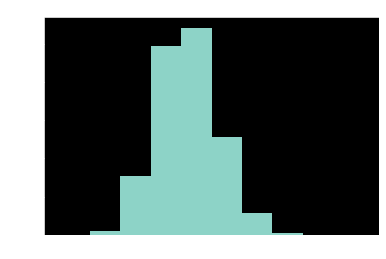

In [37]:
pd.Series(code_task_similarity.reshape(-1)).plot.hist()

In [38]:
pd.Series(code_task_similarity.reshape(-1)).describe()

count    7.605323e+07
mean     1.349400e-01
std      1.127943e-01
min     -3.442661e-01
25%      5.589901e-02
50%      1.303803e-01
75%      2.095672e-01
max      7.951401e-01
dtype: float64

In [39]:
task_similarities[6]

(Int64Index([138, 857, 890], dtype='int64'),
 array([0.12210143, 0.12210143, 0.23171246], dtype=float32))

In [40]:
tasks.iloc[code_task_similarity[0].argmax()]

area                computer-vision
task                brdf estimation
task_description                NaN
Name: 598, dtype: object

In [41]:
pd.Series(code_task_similarity[0]).sort_values()[-20:]

882     0.230746
925     0.230746
595     0.232225
606     0.234221
1063    0.238678
1229    0.242139
138     0.243369
857     0.243369
1094    0.252715
1001    0.257479
2       0.258088
991     0.263598
679     0.275932
1019    0.276297
1112    0.277429
605     0.293174
635     0.304828
1056    0.307086
1089    0.320806
598     0.341852
dtype: float32

In [42]:
i = 7 
task_similarities[i]

(Int64Index([138, 857, 890], dtype='int64'),
 array([ 0.05876533,  0.05876533, -0.04472627], dtype=float32))

<AxesSubplot:ylabel='Frequency'>

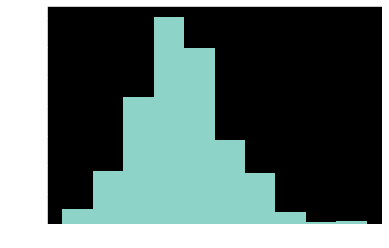

In [43]:
pd.Series(code_task_similarity[7]).plot.hist()

In [46]:
code_task_similarity

array([[ 0.12047012,  0.1088477 ,  0.2580884 , ...,  0.07515857,
         0.0770945 ,  0.13699791],
       [ 0.21861146,  0.01043667,  0.19694343, ...,  0.05449983,
        -0.01982843,  0.15897007],
       [-0.06526994, -0.00577282,  0.06488507, ...,  0.0720339 ,
        -0.07860072,  0.14993821],
       ...,
       [ 0.25663382,  0.17997906,  0.3631241 , ...,  0.23886147,
         0.23127438,  0.17720753],
       [ 0.19653183,  0.23862082,  0.492301  , ...,  0.18633887,
         0.21899685,  0.30666316],
       [ 0.00739896,  0.00855942,  0.07353381, ..., -0.08617901,
         0.0100208 , -0.01266319]], dtype=float32)

In [47]:
%load_ext autoreload

In [48]:
import findkit

In [49]:
%%time
index = findkit.index.NMSLIBIndex.build(
    code_emb.cpu().numpy(),
    metadata=functions.reset_index(drop=True).drop(columns=["Unnamed: 0"]),
    metric="cosinesimil"
)

CPU times: user 4min 50s, sys: 1.2 s, total: 4min 51s
Wall time: 9.57 s


In [50]:
described_tasks_sample = described_tasks[::10]

In [51]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.classes_ = functions['repo_name'].unique()

In [52]:
function_repo_labels = label_encoder.fit_transform(functions['repo_name'])

In [53]:
code_emb.shape

torch.Size([61482, 768])

In [54]:
repo_embeddings_mean = torch_scatter.scatter_mean(code_emb.T, torch.LongTensor(function_repo_labels).cuda()).T
repo_embeddings_max = torch_scatter.scatter_max(code_emb.T, torch.LongTensor(function_repo_labels).cuda())[0].T

In [ ]:
repo_embeddings = torch.column_stack([repo_embeddings_mean, repo_embeddings_max])

In [ ]:
repo_embeddings.shape

In [ ]:
repo_metadata = functions[['repo_name', 'tasks']].drop_duplicates(subset=["repo_name"])
repo_labels = label_encoder.transform(repo_metadata['repo_name'])

In [ ]:
repo_index = findkit.index.NMSLIBIndex.build(repo_embeddings[repo_labels].cpu().numpy(), repo_metadata, metric="cosinesimil")

In [ ]:
import numpy as np

def get_query_emb(query):
    emb = sentence_model.encode(query)
    return np.stack([emb, emb])

In [ ]:
repo_metadata = functions[['repo_name', 'tasks']].drop_duplicates(subset=["repo_name"])

In [ ]:
query

In [ ]:
query_row = described_tasks_sample.iloc[5]
query = query_row['task'] #+ "\n" + query_row['task_description']

In [ ]:
query

In [ ]:
repo_index.find_similar(get_query_emb(query), 10)

In [ ]:
def hits_at_rouge(rouge_scores, rouge_thresholds={"rougeL": 0.5}):
    return [
        rouge_score
        for rouge_score in rouge_scores
        if all(
            [
                (rouge_score[rouge_type].recall >= rouge_thresholds[rouge_type])
                for rouge_type in rouge_thresholds.keys()
            ]
        )
    ]

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

queries = []
n_hits = []
for i in range(len(described_tasks_sample)):
    query_row = described_tasks_sample.iloc[i]
    query_id = query_row['task']
    query = query_row['task'] + "\n" + query_row['task_description']
    query_emb = get_query_emb(query)
    results = repo_index.find_similar(query_emb, 10)
    queries.append(query_row['task'])
    results_tasks = results['tasks'].explode()
    rouge_scores = [scorer.score(task, query_id) for task in results_tasks.values] 
    n_hits.append(len(hits_at_rouge(rouge_scores)))
    
hits_df = pd.DataFrame(list(zip(queries, n_hits)), columns=["tasks", "n_hits"])

In [ ]:
hits_df.describe()

In [ ]:
pd.DataFrame(list(zip(queries, n_hits)), columns=["tasks", "n_hits"]).plot.hist()

## TODO: a co jakby użyć dekodera do scoringu?


In [ ]:
pd.DataFrame(list(zip(queries, n_hits))).mean()

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=False)

In [ ]:
hypothesis = "speech to speech translation"

In [ ]:
def hits_at_rouge(rouge_scores, rouge_thresholds={"rougeL": 0.5}):
    return [
        rouge_score
        for rouge_score in rouge_scores
        if all(
            [
                (rouge_score[rouge_type].recall >= rouge_thresholds[rouge_type])
                for rouge_type in rouge_thresholds.keys()
            ]
        )
    ]

In [ ]:
hits_at_rouge(rouge_scores)

In [ ]:
_rouge_res = scorer.score(ngram, hypothesis)

In [ ]:
tex_spaces = 

In [ ]:
dict()

In [ ]:
rouge_scores = [
    scorer.score(ngram, hypothesis)
    for ngram in results['tasks'].explode()
]

In [ ]:
hits_at_rouge(rouge_scores)

In [ ]:
results['tasks'].explode()

In [ ]:
results['tasks'].explode()

In [ ]:
res['distance'] = results['']

In [ ]:
index.get_metadata()

In [ ]:
isorted(code_task_similarity[i], reverse=True)

In [ ]:
hnsw_index.get

In [ ]:
index.find_similar(sentence_model.encode("similarity learning"), 5)

In [ ]:
functions.iloc[0]

In [55]:
from transformers import RobertaTokenizer, T5ForConditionalGeneration

t5_tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base-multi-sum')
t5_model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base-multi-sum')

text = """def svg_to_image(string, size=None):
if isinstance(string, unicode):
    string = string.encode('utf-8')
    renderer = QtSvg.QSvgRenderer(QtCore.QByteArray(string))
if not renderer.isValid():
    raise ValueError('Invalid SVG data.')
if size is None:
    size = renderer.defaultSize()
    image = QtGui.QImage(size, QtGui.QImage.Format_ARGB32)
    painter = QtGui.QPainter(image)
    renderer.render(painter)
return image"""



In [56]:
text = """
def test_update_from_traffic_sim(social_vehicle, provider_vehicle):
    social_vehicle.control(pose=provider_vehicle.pose, speed=provider_vehicle.speed)
    (sv_position, sv_heading) = social_vehicle.pose.as_sumo(social_vehicle.length, Heading(0))
    (provider_position, provider_heading) = provider_vehicle.pose.as_sumo(social_vehicle.length, Heading(0))
    assert np.isclose(sv_position, provider_position, rtol=0.01).all()
    assert math.isclose(sv_heading, provider_heading, rel_tol=1e-05)
    assert (social_vehicle.speed == provider_vehicle.speed)
"""

In [57]:
sebis_model = "SEBIS/code_trans_t5_large_code_documentation_generation_python_multitask"
code_trans_model=transformers.AutoModelForSeq2SeqLM.from_pretrained(sebis_model)
code_trans_tokenizer=transformers.AutoTokenizer.from_pretrained(sebis_model, skip_special_tokens=True)

In [58]:
texts = index.find_similar(sentence_model.encode("similarity learning"), 5)['function_code']

In [59]:
input_ids = code_trans_tokenizer(list(texts), return_tensors="pt", padding=True).input_ids.cuda()
code_trans_model = code_trans_model.cuda()

In [60]:
input_ids.shape

torch.Size([5, 365])

In [61]:
for i in range(len(input_ids)):
    print("### CODE: ")
    print(texts.iloc[i])
    ids = input_ids[i]
    generated_ids = code_trans_model.generate(ids.reshape(1,-1), max_length=20, min_length=10, num_beams=10)
    print("### SUMMARY: ")
    print(code_trans_tokenizer.decode(generated_ids[0], skip_special_tokens=True))
    # this prints: "Convert a SVG string to a QImage."

### CODE: 
class ModelSimilarity(SimilarityMeasure):
    '\n    Similarity defined by the model. The model parameters are given by the first element of the pair.\n    The similarity is evaluated by doing the forward pass (inference) on the parametrized model with\n    the second element of the pair as input.\n    '

    def __init__(self, model):
        self.model = model

    def forward(self, x):
        model_parameters = x[0]
        model_inputs = x[1]
        cur_outputs = model_inputs
        for (layer_model, parameter_map) in self.model:
            param_dict = {}
            for (param_name, param_slice_reshape) in parameter_map.items():
                if isinstance(param_slice_reshape, SliceReshaper):
                    val = param_slice_reshape(model_parameters)
                else:
                    val = param_slice_reshape
                param_dict[param_name] = val
            cur_outputs = layer_model(cur_outputs, **param_dict)
        return cur_outputs
### SU

In [120]:
repo_functions = raw_functions_all[raw_functions_all['repo_name'] == "trangvu/ape-npi"]

In [121]:
repo_functions

,Unnamed: 0,repo_name,path,function_name,function_code
0,0,trangvu/ape-npi,run-tests.py,failure,def failure(message):\n print('{}failure: {...
1,1,trangvu/ape-npi,run-tests.py,success,def success(message):\n print('{}success: {...
2,2,trangvu/ape-npi,run-tests.py,get_best_score,def get_best_score(log_file):\n scores = []...
3,3,trangvu/ape-npi,run-tests.py,run,"def run(dir_, score=None):\n config_file = ..."
4,4,trangvu/ape-npi,translate/import_graph.py,ImportGraph,class ImportGraph():\n ' Importing and run...
...,...,...,...,...,...
116,116,trangvu/ape-npi,scripts/speech/extract-audio-features.py,read_features,def read_features(filename):\n all_feats = ...
117,117,trangvu/ape-npi,scripts/post_editing/well-formed.py,is_well_formed,def is_well_formed(line):\n if (len(line) <...
118,118,trangvu/ape-npi,scripts/post_editing/apply-edits.py,reverse_edits,"def reverse_edits(source, edits, fix=True, str..."
119,119,trangvu/ape-npi,scripts/post_editing/extract-edits.py,levenshtein_legacy,@functools.lru_cache(maxsize=1024)\ndef levens...


In [271]:
#repo_functions = repo_functions.iloc[:10]

In [272]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM 

In [273]:
from transformers import T5Tokenizer, T5ForConditionalGeneration


model_name = 'doc2query/stackexchange-title-body-t5-base-v1'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [277]:
model = model.cuda()

In [132]:
code_trans_model = code_trans_model.cuda()

In [274]:
import numpy as np


def batched_generate(model, tokenizer, texts, batch_size=32, max_length=64, num_beams=5, **kwargs):
    generated_sequences = []
    for i in range(int(np.ceil(len(texts) / batch_size))):
        batch_start = i * batch_size
        batch_end = (i+1) * batch_size
        text_chunk = texts[batch_start:batch_end]
        input_ids = tokenizer.batch_encode_plus(text_chunk, max_length=320, padding=True, truncation=True, return_tensors='pt').to(model.device)
        outputs = model.generate(
            **input_ids,
            max_length=max_length,
            num_beams=num_beams,
            num_return_sequences=1)

        batch_generated_sequences = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        generated_sequences  += batch_generated_sequences 
    return generated_sequences 

In [278]:
%%time
batched_generate(model, tokenizer, repo_functions['function_code'].iloc[:10].to_list())

CPU times: user 452 ms, sys: 4.45 ms, total: 456 ms
Wall time: 429 ms


['How to format error message in python?',
 'How to print success message in python?',
 'Get the best score from a log file',
 'Seq2seq.sh in Python',
 'Importing and running isolated TF graph',
 'How to use tf.train.save() in python?',
 "tf.variable_scope() wrapper that automatically handles the reuse' parameter",
 'RNNCell wrapper class for LSTM',
 'Multi-encoder in Keras',
 'tf.nn.dropout is not working in python']

In [215]:
input_ids = tokenizer.encode(input_texts, max_length=320, truncation=True, return_tensors='pt').to(model.device)

In [221]:
input_texts[0]

"# run-tests.py\ndef failure(message):\n    print('{}failure: {}{}'.format(FAIL, message, ENDC))"

In [230]:
input_texts = repo_functions['function_code'].iloc[:1]
input_ids = tokenizer.batch_encode_plus(input_texts, max_length=320, truncation=True, padding=True, return_tensors='pt').to(model.device)
input_ids['input_ids']

tensor([[   20,    89,  3338,   599,  2687,     7,   545,    61,    10,  2281,
           599,    31,     2,    89,     9,   173,  1462,    10,     3,     2,
            31,     5,  8995,   599,   371, 22862,     6,  1569,     6,     3,
         14920,   254,    61,    61,     1]], device='cuda:0')

In [233]:
outputs = model.generate(
    **input_ids,
    max_length=64,
    num_beams=5,
    num_return_sequences=1)


In [239]:
generated_query = tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [240]:
generated_query

['How to format error message in python?']

In [190]:
function_summaries = get_summaries(model, tokenizer, repo_functions['function_code'])

100%|██████████| 121/121 [00:29<00:00,  4.15it/s]


In [160]:

texts = repo_functions['function_code']
paths = repo_functions['path']
names = repo_functions['function_name']

generated_queries = []

input_texts = [
    "# {}\n{}".format(path, text)
    for path, function_name, text in tqdm.tqdm(zip(paths, names, texts), total=len(texts))
]
summaries = get_summaries(model, tokenizer, input_texts)

repo_functions['generated_queries'] = summaries 

100%|██████████| 121/121 [00:51<00:00,  2.36it/s]
<ipython-input-160-126da3c4dbd5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repo_functions['generated_queries'] = summaries


In [151]:
papers_with_readmes_df = pd.read_csv("../../output/papers_with_readmes.csv")

In [175]:
readme_sample = papers_with_readmes_df['readme'].dropna().iloc[:100]
title_sample = papers_with_readmes_df[['title', 'readme']].dropna().iloc[:100]['title']

In [186]:
summaries

[["How to print error message in python using failure: '.format(FAIL, message, ENDC)?",
  "How to print error message in python using failure: '.format(FAIL, message, ENDC)?",
  "How to print error message in python using failure: '.format(FAIL, message, ENDC)",
  "How to print error message in python using failure: '.format(FAIL, message, ENDC)",
  "How to print error message in python using failure: '.format(FAIL, message, ENDC) in python?"],
 ['How to print success message in python?',
  'How to format success message in python?',
  'How to print success message in python using python?',
  'How to print success message in python',
  'How to print a success message in python?'],
 ['Getting the best score from a python python python python python python python python python python python',
  'Getting the best score from a python python python python python python python python python python script',
  'Getting the best score from a python python python python python python python pyth

In [184]:
functions['repo_name'].value_counts()[50:]

benedekrozemberczki/karateclub       83
facebookresearch/pythia              83
KAIST-AILab/deeprl_practice_colab    77
WING-NUS/scisumm-corpus              76
GPflow/GPflow                        75
                                     ..
mkmenta/domain_adapt_segm             1
dhlab-epfl/dhSegment-text-torch       1
ckiplab/ckiptagger                    1
gunooknam/Code_Study_Yolov3           1
kongzhiyou/darknet-master             1
Name: repo_name, Length: 11943, dtype: int64

In [171]:
readme_summaries = get_summaries(code_trans_model, code_trans_tokenizer, readme_sample)

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


In [178]:
for title, summary in zip(title_sample, readme_summaries):
    print(title)
    print(summary)

A Unifying Generative Model for Graph Learning Algorithms: Label Propagation, Graph Convolutions, and Combinations
['### Gaussian Markov Random Field Learning Algorithms', '### Gaussian Markov random field ( MRF )', '### Gaussian Markov Random Field ( Gaussian Markov Random Field ) ###', '### Gaussian Markov Random Field ( Gaussian Markov Random Field )', '### Gaussian Markov Random Field ( MRF ) ###']
Graph-based Semi-Supervised & Active Learning for Edge Flows
['### Semi-supervised Learning for Edge Flows in a network.', '### Semi-Supervised Learning for Edge Flows in a network.', '### Semi-Supervised Learning for Edge Flows ###', '### Semi-Supervised Learning for Edge Flows', '### Semi-supervised Learning for Edge Flows']
Neural Ordinary Differential Equations
['Using PyTorch to fit a spiral ODE', 'Using PyTorch to fit a spiral ODE to a spiral network.', 'Using PyTorch to fit a spiral ODE to a spiral network', 'Using PyTorch to fit a spiral ODE to a spiral ODE', 'Use PyTorch to fit 

In [185]:
list(repo_functions['generated_queries'])

[["How to print error message in python using failure: '.format(FAIL, message, ENDC)?",
  "How to print error message in python using failure: '.format(FAIL, message, ENDC)?",
  "How to print error message in python using failure: '.format(FAIL, message, ENDC)",
  "How to print error message in python using failure: '.format(FAIL, message, ENDC)",
  "How to print error message in python using failure: '.format(FAIL, message, ENDC) in python?"],
 ['How to print success message in python?',
  'How to format success message in python?',
  'How to print success message in python using python?',
  'How to print success message in python',
  'How to print a success message in python?'],
 ['Getting the best score from a python python python python python python python python python python python',
  'Getting the best score from a python python python python python python python python python python script',
  'Getting the best score from a python python python python python python python pyth

In [139]:
repo_functions

,Unnamed: 0,repo_name,path,function_name,function_code,generated_queries
0,0,trangvu/ape-npi,run-tests.py,failure,def failure(message):\n print('{}failure: {...,How to print a failure message in run-tests.py
1,1,trangvu/ape-npi,run-tests.py,success,def success(message):\n print('{}success: {...,Run-tests.py with a success message
2,2,trangvu/ape-npi,run-tests.py,get_best_score,def get_best_score(log_file):\n scores = []...,Get the best score from a log file.
3,3,trangvu/ape-npi,run-tests.py,run,"def run(dir_, score=None):\n config_file = ...",Run seq2seq and compare scores
4,4,trangvu/ape-npi,translate/import_graph.py,ImportGraph,class ImportGraph():\n ' Importing and run...,Importing and running isolated TF graph
...,...,...,...,...,...,...
116,116,trangvu/ape-npi,scripts/speech/extract-audio-features.py,read_features,def read_features(filename):\n all_feats = ...,Read audio features from a file.
117,117,trangvu/ape-npi,scripts/post_editing/well-formed.py,is_well_formed,def is_well_formed(line):\n if (len(line) <...,"Return True if a line is well-formed, False ot..."
118,118,trangvu/ape-npi,scripts/post_editing/apply-edits.py,reverse_edits,"def reverse_edits(source, edits, fix=True, str...",Reverse the order of words in a list of edits.
119,119,trangvu/ape-npi,scripts/post_editing/extract-edits.py,levenshtein_legacy,@functools.lru_cache(maxsize=1024)\ndef levens...,Levenshtein algorithm for extracting edits usi...


In [129]:
paperswithcode_df[paperswithcode_df['repo'] == "trangvu/ape-npi"]

,Unnamed: 0,paper_url,paper_title,paper_arxiv_id,paper_url_abs,paper_url_pdf,repo_url,mentioned_in_paper,mentioned_in_github,framework,repo,title,abstract,tasks,least_common_task
38648,38648,https://paperswithcode.com/paper/automatic-pos...,Automatic Post-Editing of Machine Translation:...,NaN,https://www.aclweb.org/anthology/D18-1341/,https://www.aclweb.org/anthology/D18-1341,https://github.com/trangvu/ape-npi,False,False,tf,trangvu/ape-npi,Automatic Post-Editing of Machine Translation:...,Automated Post-Editing (PE) is the task of aut...,"[automatic post editing, machine translation]",automatic post editing


In [86]:
print("\nGenerated Queries:")
for i in range(len(outputs)):
    print(f'{i + 1}: {query}')


Generated Queries:
1: Reading a vocabulary from a file using python
2: Reading a vocabulary from a file
3: Reading a vocabulary from a file and enumerating the words in it
4: Reading a vocabulary from a text file using python
5: Reading a vocabulary from a text file in python
